In [1]:
%load_ext autoreload

import os, sys
import networkx as nx

sys.path.insert(0, "../")
sys.path.insert(0, "/home/j/joppich/.local/lib/python3.11/site-packages/")

%autoreload 2
from mikg.kgraph import *
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

import random
random.seed(42)

import pickle

In [2]:
kg = KGraph()

In [3]:
kg.load_kgraph_base("../data/", TFs=True, go=True, omnipath=True, opentargets=True, reactome=True, STRING=True, NPINTER=False, kegg=True)

/mnt/raidbio/extproj/projekte/regulatory_networks/scripts/../mikg/load_utils.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf["score"] = subdf[use_evidences].max(axis=1)/1000


HMS:0:00:11.686330 626,136 annotations READ: ../data/goa_human.gaf 
../data/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms


/mnt/raidbio/extproj/projekte/regulatory_networks/scripts/../mikg/load_utils.py:236: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  opd  = pd.read_csv(omnipathDB, sep="\t")


Removing 14822 singletons


In [4]:
kg.get_edge_between_type()

Counter({('gene', 'geneset'): 837651,
         ('gene', 'gene'): 317486,
         ('geneset', 'geneset'): 74634,
         ('TF;gene', 'geneset'): 74127,
         ('TF;gene', 'gene'): 45335,
         ('gene', 'disease'): 43297,
         ('disease', 'drug'): 35017,
         ('gene', 'TF;gene'): 16909,
         ('TF;gene', 'TF;gene'): 11225,
         ('gene', 'drug'): 7899,
         ('TF;gene', 'disease'): 5105,
         ('gene', 'disease;geneset'): 1714,
         ('TF;gene', 'miRNA;ncRNA'): 1487,
         ('gene;lncRNA;ncRNA', 'geneset'): 444,
         ('gene', 'miRNA;ncRNA'): 355,
         ('TF;gene', 'drug'): 341,
         ('geneset', 'disease;geneset'): 200,
         ('TF;gene', 'disease;geneset'): 147,
         ('disease;geneset', 'geneset'): 95,
         ('gene', 'gene;lncRNA;ncRNA'): 36,
         ('disease;geneset', 'drug'): 34,
         ('gene;lncRNA;ncRNA', 'gene'): 29,
         ('TF;gene', 'gene;lncRNA;ncRNA'): 15,
         ('gene;lncRNA;ncRNA', 'TF;gene'): 7,
         ('disease

In [5]:
kg.get_node_types()

Counter({'geneset': 55100,
         'gene': 41901,
         'disease': 7781,
         'drug': 3195,
         'TF;gene': 1629,
         'miRNA;ncRNA': 299,
         'disease;geneset': 61,
         'gene;lncRNA;ncRNA': 22})

In [6]:
kg.get_edge_types()

Counter({'part_of': 702007,
         'interacts': 348285,
         'relevant_in': 205734,
         'activates': 156613,
         'affected_by': 35051,
         'represses': 17665,
         'target_of': 8240})

In [ ]:
kg.get_edge_types(field="source")

Counter({'kegg': 501176,
         'GeneOntology': 361812,
         'STRING': 299540,
         'reactome': 125897,
         'omnipath': 93344,
         'opentargets': 91826})

In [ ]:
kg.get_edge_edge_types()

Counter({('gene', 'geneset', 'part_of'): 580671,
         ('gene', 'gene', 'interacts'): 272530,
         ('gene', 'geneset', 'relevant_in'): 185260,
         ('geneset', 'geneset', 'part_of'): 74634,
         ('gene', 'geneset', 'activates'): 71720,
         ('TF;gene', 'geneset', 'part_of'): 46000,
         ('gene', 'disease', 'interacts'): 43297,
         ('gene', 'gene', 'activates'): 35200,
         ('disease', 'drug', 'affected_by'): 35017,
         ('TF;gene', 'gene', 'activates'): 30295,
         ('TF;gene', 'geneset', 'relevant_in'): 18710,
         ('gene', 'TF;gene', 'interacts'): 11309,
         ('TF;gene', 'gene', 'interacts'): 10588,
         ('gene', 'gene', 'represses'): 9756,
         ('TF;gene', 'geneset', 'activates'): 9417,
         ('gene', 'drug', 'target_of'): 7899,
         ('TF;gene', 'TF;gene', 'interacts'): 5239,
         ('TF;gene', 'disease', 'interacts'): 5105,
         ('TF;gene', 'TF;gene', 'activates'): 4727,
         ('TF;gene', 'gene', 'represses'): 4

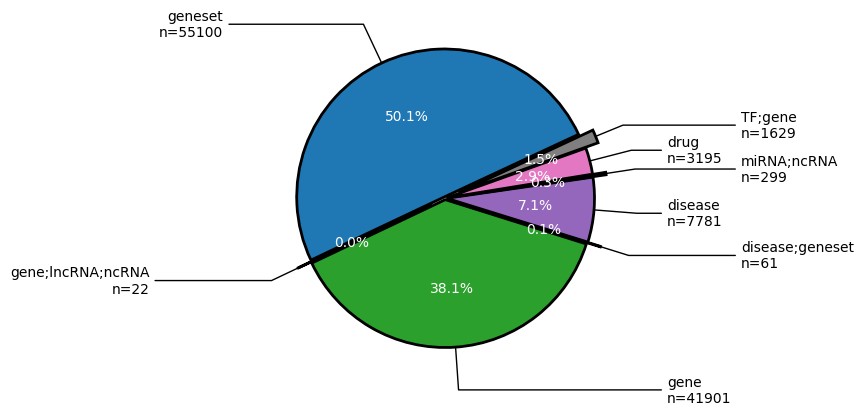

In [ ]:
kg.plot_node_types()

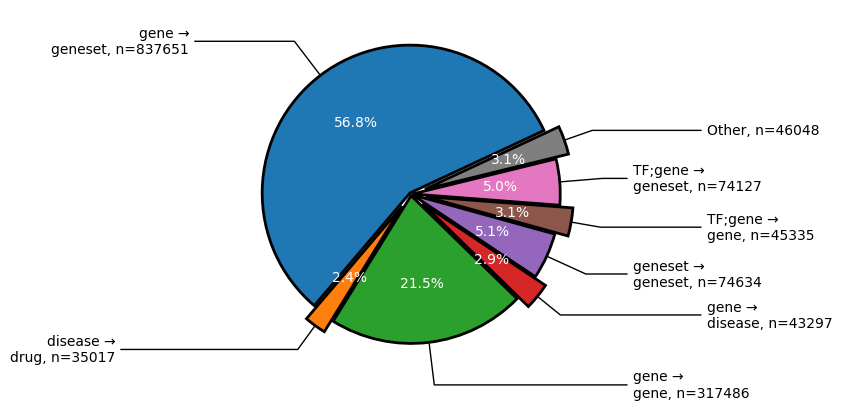

In [ ]:
kg.plot_edge_between_types()

In [ ]:
print(kg.kg)

DiGraph with 109988 nodes and 1473595 edges


In [ ]:
for x in kg.kg.nodes:
    if "gene" in kg.kg.nodes[x]["type"] and "miRNA" in kg.kg.nodes[x]["type"]:
        print(x, kg.kg.nodes[x])

In [ ]:
kg.save_kgraph("../data/initial_base_graph.out")

In [ ]:
kg = KGraph()
kg.load_kgraph("../data/initial_base_graph.out")

In [ ]:
exprDF = pd.read_csv("../seq_data/expression_mean_df.tsv", sep="\t")
cmDF = exprDF[exprDF.group == "Cardiomyocyte"]
cmDF

,group,gene,min,percentile_25,median,percentile_75,max,mean,num,sd,group_cells,perc_expr
22891,Cardiomyocyte,A1BG,0.218642,0.439190,0.607427,0.831411,2.456248,0.709995,351,0.395967,64510,0.005441
22892,Cardiomyocyte,A1BG-AS1,0.214143,0.456117,0.643483,0.936906,3.038826,0.806031,461,0.518502,64510,0.007146
22893,Cardiomyocyte,A1CF,0.208636,0.422485,0.557386,0.773439,3.025672,0.637636,706,0.321588,64510,0.010944
22894,Cardiomyocyte,A2M,0.181245,0.651118,0.944811,1.398837,3.792171,1.075190,32973,0.547520,64510,0.511130
22895,Cardiomyocyte,A2M-AS1,0.185317,0.412732,0.539294,0.709554,2.699968,0.602207,3160,0.286947,64510,0.048985
...,...,...,...,...,...,...,...,...,...,...,...,...
50958,Cardiomyocyte,ZXDC,0.185317,0.610198,0.829333,1.097115,3.521134,0.891553,35191,0.378761,64510,0.545512
50959,Cardiomyocyte,ZYG11A,0.224826,0.414667,0.540848,0.712375,2.653949,0.637458,303,0.367307,64510,0.004697
50960,Cardiomyocyte,ZYG11B,0.187795,0.600248,0.812252,1.080384,3.494183,0.880513,33025,0.386580,64510,0.511936
50961,Cardiomyocyte,ZYX,0.193169,0.445595,0.595571,0.835346,3.001737,0.705213,5338,0.395080,64510,0.082747


In [ ]:
exprDFs = {}

for group in exprDF.group.unique():
    exprDFs[group] = exprDF[exprDF.group == group].copy()

print([x for x in exprDFs])

['Adipocyte', 'Cardiomyocyte', 'Cycling cells', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'vSMCs']


In [ ]:
kg.add_gene_expression(cmDF)

Measured Genes 28072
Found Genes 19731


In [ ]:
mNS = MeanNetworkScorer()
mNS.score_nodes_from_properties(kg)
mNS.score(kg)

In [ ]:
def get_score(x):
    if "gene" in x.get("type", []):
        return x.get("score", 0)
    else:
        return x.get("score", 0)

In [ ]:
kg.get_node_types()

In [ ]:
kg.plot_node_attribute_distribution(get_score)

In [ ]:
kg.plot_node_attribute_distribution(get_score, node_types=["drug"])

In [ ]:
kg.plot_score_histogram(edge_types=[("gene", "gene")], score_accessor=lambda x: x.get("score_zscore", 0))

In [ ]:
kg.plot_score_histogram(edge_types=[("gene", "geneset")], score_accessor=lambda x: x.get("score_zscore", 0))

In [ ]:
kg

In [ ]:
kg.plot_score_histogram(score_accessor=lambda x: x.get("score_zscore", 0))

In [ ]:
kg.plot_score_histogram(edge_types=[("gene", "gene")], score_accessor=lambda x: x.get("score_zscore", 0))

In [ ]:
kg.plot_score_histogram(edge_types=[("gene", "disease")], score_accessor=lambda x: x.get("score_zscore", 0))

In [ ]:
kg.plot_score_histogram(edge_types=[("gene", "geneset")], score_accessor=lambda x: x.get("score_zscore", 0))

In [ ]:
kg.plot_score_violin(per_edge_type=True, single_edge_types=True, score_accessor=lambda x: x.get("score_zscore", 0))

In [ ]:
kg.plot_score_histogram(edge_types=[("gene", "drug")], score_accessor=lambda x: x.get("score_zscore", 0))

In [ ]:
kg.plot_edge_sources()

In [ ]:
kg.plot_node_types()

In [ ]:
kg.plot_edge_types()

In [ ]:
kg.plot_edge_between_types()